# Week 13

Neural Networks for images

In [2]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/image_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/nn_utils.py

!wget -qO- https://github.com/PSAM-5020-2025S-A/5020-utils/releases/latest/download/lfw.tar.gz | tar xz

In [15]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from torch import Tensor, nn

from data_utils import LFWUtils, classification_error, display_confusion_matrix
from image_utils import make_image
from nn_utils import get_labels, get_num_params

### Classification Review

Can we use NN models to do classification of images? Sure.

The steps are the same, we just have to load image data and adapt the cost/loss function to calculate some kind of classification metric instead.

We'll use the _Labeled Faces in the Wild_ dataset from last homework.

The steps for setting up the classification model will be:

- Load dataset and do any kind of pre-pre-processing
- Split data into train/test datasets
- Perform any kind of pre-processing
- Split independent features and classification label and load them into `Tensors`
- Build a NN model
- Set up an optimizer
- Pick a cost/loss function
- Implement an evaluation function and any other kind of visualization that helps quantify/evaluate the model
- Train model
- Evaluate

### Load and split Dataset

The `LFWUtils.train_test_split(0.5)` function gives us some `Python` objects we can use to create our `Tensor`s.

The `pixels` key gives us a list of the images' pixel data, and the `label` key gives us the images' label IDs.

We don't have to do any normalization since the pixels will be in a known, well-defined, range of $[0 \text{ - } 255]$.

The only thing we have to do differently is cast the labels `Tensor` to `long`. This is to ensure the numbers in those `Tensor`s are whole numbers and don't have decimal points.

In [17]:
train, test = LFWUtils.train_test_split(0.5)

x_train = Tensor(train["pixels"])
y_train = Tensor(train["labels"]).long()

x_test = Tensor(test["pixels"])
y_test = Tensor(test["labels"]).long()

print("Dataset Samples")
print("\tTrain:", len(x_train))
print("\tTest:", len(x_test))

print("\nDataset Shape:", list(x_train.shape))
print("\nSample Shape:", list(x_train[0].shape))

Dataset Samples
	Train: 445
	Test: 438

Dataset Shape: [445, 22100]

Sample Shape: [22100]


### Look at data

We can visualize some of the images, their text labels and label IDs

0 annan


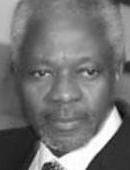

In [18]:
idx = 0

id = train["labels"][idx]
print(id, LFWUtils.LABELS[id])
display(make_image(train["pixels"][idx], width=130))

### Model, Optimizer and Cost Function

We'll start with the simplest kind of network again, with just an input and an output layer.

The input layer has as many neurons as the number of pixels in each image, and the output layer has one neuron per possible class.

It looks like this, and is juts like our regression network above, but has more output neurons:

<img src="./imgs/linear_22100x26.jpg" width="800px"/>

Our optimizer will be `SGD` again.

Our cost function is a bit different. Previously, we used $L2$ distances to calculate the root mean square error of our regression predictions and used that value as the cost function for gradient descent.

In order to use gradient descent for classification, we have to turn the discrete nature of our labels/classes and their errors into something that has smooth and integratable slopes.

That's what the `CrossEntropyLoss()` function does for us. It looks at the outputs of our model and transforms the regression-type continuous values at our neuron outputs into class prediction probabilities in a way that gradient descent still works.

The loss for a given prediction is calculated by the equation:
$$-\log\left(\frac{e^{y_c}}{\sum_{i=0}^{C}e^{y_i}}\right)$$

Where, $y_c$ is the value of the output neuron that corresponds to the correct class of the prediction, and $y_i$ are all of the output neuron values. This equation, with its $e^y$ and $\log()$, results in a very high value whenever the correct neuron is not activated, but gives us a $0$ (or a value close to $0$) when the correct output neuron is the most strongly activated neuron amongst a few activated neurons.

More importantly, this equation is integratable and can be used in the calculation of gradients for our neuron parameters.

In [19]:
model = nn.Linear(x_train.shape[1], len(y_train.unique()))

learning_rate = 1e-6
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

### Test Shapes

We're just going to put the inputs through the model to check if the parameter shapes match.

In [20]:
out = model(x_train)

print("Input shape:", x_train.shape)
print("Output shape:", out.shape)

Input shape: torch.Size([445, 22100])
Output shape: torch.Size([445, 25])


### Train the Model

We can train the model now.

The `x` and `y` variables below actually hold pixel and label information for $445$ images. We feed all of them into the network at once and predict all of the labels at the same time. We can then calculate loss, calculate the slope of the loss function, update model parameters, zero the gradients, and repeat.

We'll add an evaluation function that we'll run every once in a while within the training loop. This evaluation function will run on all of our data, training and test, to see when/if the model starts to overfit. This evaluation function also gives us something a little more legible than the `CrossEntropyLoss()` value, which is the sum of the "negative log likelihood" of our predictions.

We'll just use the `get_labels()` function from the `Homework12_utils` class. It will run our model on all samples of a dataset and extract the class value from the most-activated neuron.

In [21]:
for e in range(32):
  # clear slopes in optimizer
  optim.zero_grad()

  # compute labels from model
  labels_pred = model(x_train)

  # calculate how wrong model is
  loss = loss_fn(labels_pred, y_train)

  # compute slopes for cost function
  loss.backward()

  # adjust model's parameters
  optim.step()

  # keep an eye on loss as we train
  if e % 4 == 3:
    train_predictions = get_labels(model, x_train)
    test_predictions = get_labels(model, x_test)
    train_error = classification_error(y_train, train_predictions)
    test_error = classification_error(y_test, test_predictions)
    print(f"Epoch: {e} loss: {loss.item():.4f}, train error: {train_error:.4f}, test error: {test_error:.4f}")

Epoch: 3 loss: 106.9389, train error: 0.9146, test error: 0.9247
Epoch: 7 loss: 133.0348, train error: 0.9303, test error: 0.9201
Epoch: 11 loss: 124.3817, train error: 0.8831, test error: 0.9132
Epoch: 15 loss: 118.6882, train error: 0.8202, test error: 0.8425
Epoch: 19 loss: 112.9466, train error: 0.8202, test error: 0.8493
Epoch: 23 loss: 65.2093, train error: 0.8270, test error: 0.8790
Epoch: 27 loss: 57.6506, train error: 0.6629, test error: 0.7534
Epoch: 31 loss: 35.6724, train error: 0.5618, test error: 0.7260


### Interpretation

The loss/cost value can oscillate up and down a bit, but, overall should steadily decrease. This oscillation has to do with the `SGD` optimizer and how it makes some decisions that it sometimes has to undo, but overall, the model looks like it's learning.

Do we want to keep running this cell until the loss gets really small?

How low can we get our test error ?

### Add Layers

Maybe we can improve our classification by adding some hidden layers.

We might want to do this:

In [22]:
model =  nn.Sequential(
  nn.Linear(x_train.shape[1], x_train.shape[1] // 2),
  nn.Sigmoid(),

  nn.Linear(x_train.shape[1] // 2, x_train.shape[1] // 16),
  nn.Sigmoid(),

  nn.Linear(x_train.shape[1] // 16, x_train.shape[1] // 32),
  nn.Sigmoid(),

  nn.Linear(x_train.shape[1] // 32, len(y_train.unique())),
)

But, this neural network has these many parameters:

In [23]:
get_num_params(model)

260448336

That's a lot.

Our regular codespaces computer won't be able to optimize a network of this size in a reasonable amount of time.

We saw in the homework that if we want to add layers we have to reduce the number of our features. So .... PCA.

In [24]:
std = StandardScaler()
pca = PCA(n_components=0.9999)

x_pca_train = pca.fit_transform(std.fit_transform(train["pixels"]))
x_pca_test = pca.transform(std.transform(test["pixels"]))

print(pca.n_components_, pca.explained_variance_ratio_.sum())

x_train = Tensor(x_pca_train)
y_train = Tensor(train["labels"]).long()

x_test = Tensor(x_pca_test)
y_test = Tensor(test["labels"]).long()

x_train.shape

442 0.9999313114185984


torch.Size([445, 442])

In [25]:
model =  nn.Sequential(
  nn.Linear(x_train.shape[1], x_train.shape[1] // 2),
  nn.Sigmoid(),

  nn.Linear(x_train.shape[1] // 2, x_train.shape[1] // 16),
  nn.Sigmoid(),

  nn.Linear(x_train.shape[1] // 16, x_train.shape[1] // 32),
  nn.Sigmoid(),

  nn.Linear(x_train.shape[1] // 32, len(y_train.unique())),
)

learning_rate = 1e-1
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

out = model(x_train)

print("Input shape:", x_train.shape)
print("Output shape:", out.shape)
print("Num Params:", get_num_params(model))

Input shape: torch.Size([445, 442])
Output shape: torch.Size([445, 25])
Num Params: 104611


In [26]:
for e in range(256):
  optim.zero_grad()
  labels_pred = model(x_train)
  loss = loss_fn(labels_pred, y_train)
  loss.backward()
  optim.step()

  if e % 32 == 31:
    train_predictions = get_labels(model, x_train)
    test_predictions = get_labels(model, x_test)
    train_error = classification_error(y_train, train_predictions)
    test_error = classification_error(y_test, test_predictions)
    print(f"Epoch: {e} loss: {loss.item():.4f}, train error: {train_error:.4f}, test error: {test_error:.4f}")

Epoch: 31 loss: 3.1704, train error: 0.9416, test error: 0.9452
Epoch: 63 loss: 3.1484, train error: 0.8225, test error: 0.8858
Epoch: 95 loss: 3.0472, train error: 0.8090, test error: 0.8584
Epoch: 127 loss: 2.7319, train error: 0.7910, test error: 0.8242
Epoch: 159 loss: 2.4191, train error: 0.6966, test error: 0.7808
Epoch: 191 loss: 2.1043, train error: 0.5955, test error: 0.7626
Epoch: 223 loss: 1.8286, train error: 0.5191, test error: 0.7352
Epoch: 255 loss: 1.6059, train error: 0.4225, test error: 0.7237


train error: 0.4225
test error 0.7237


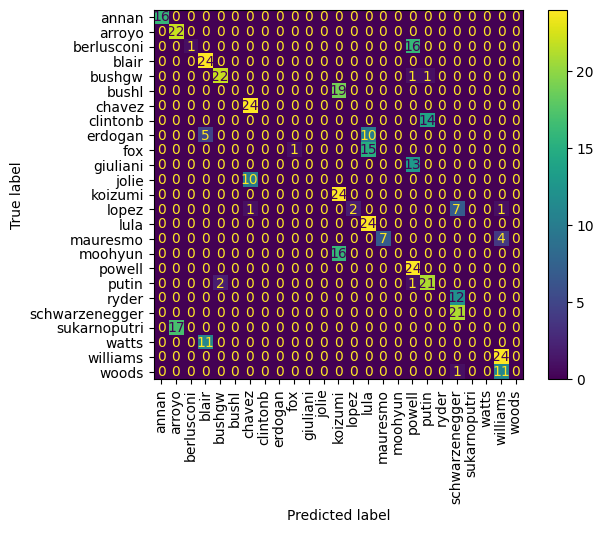

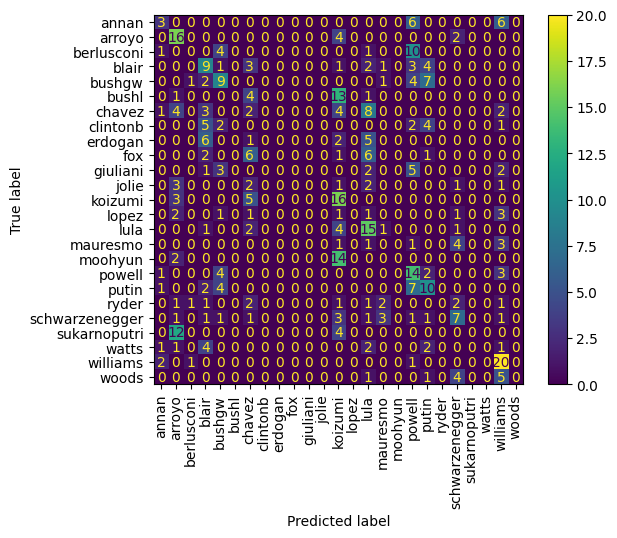

In [27]:
train_predictions = get_labels(model, x_train)
test_predictions = get_labels(model, x_test)

print("train error:", f"{classification_error(y_train, train_predictions):.4f}")
print("test error", f"{classification_error(y_test, test_predictions):.4f}")

display_confusion_matrix(y_train, train_predictions, display_labels=LFWUtils.LABELS)
display_confusion_matrix(y_test, test_predictions, display_labels=LFWUtils.LABELS)

### Interpretation

The result is mostly the same, which is not surprising.

We did add layers, but the network didn't need any extra neurons to do well on the training data.

It needs help with the testing data, or, another way to say this is: it needs help generalizing without memorizing.

### Make It Harder

Neural network models can seem simple to explain in a general sense: they're long and wide computation graphs made up of simple operations that have been tuned to achieve a specific task. Once they're training, or trained, their details and specificities are a little less easy to describe. It's hard to know exactly what each neuron is doing, and what part of the computation they are responsible for. We can train the same network, with the same parameters, using the same input data, and end up with wildly different results.

This is one reason why it's hard to debug a network when it doesn't seem to be learning properly, or when it starts to overfit and memorize the training data. Which neurons do we tune ?

One common situation that can lead to overfitting is when a network ends up with parameters that make it perform well on the training data without really activating all of its neurons. This is usually what is happening if adding layers to a network doesn't improve its performance.

One set of strategies for improving neural network training in these cases involves making the training process harder than it has to be. It's like we're challenging the neural network to learn more than it has, so that later it has an easier time with the regular data.

#### Dropout

One simple technique to achieve this is to add `Dropout` layers to our network. A `Dropout` layer is a layer of neurons that don't perform any mathematical operation, but are selectively dropped out of the network randomly during training. This has the effect of randomly changing the network's architecture during training and preventing the network from becoming too reliant on specific neurons. Instead, it encourages the network to learn more robust features by activating more diverse sets of neurons.

<img src="./imgs/dropout.jpg" width="800px"/>

#### Activation Normalization

Another technique that is used to keep our neural networks from memorizing data has to do with the range of the values that get passed between its inner layers.

Input data coming into the network is most likely normalized, but after the first layer, the network weights might really change the distribution of the data as it flows through the network. Moreover, individual batches with different input value distributions can bias the network towards certain goals.

<img src="./imgs/norm_activation.jpg" width="720px"/>

#### Batch Normalization

One way to handle these situations is to normalize the data as it passes through the network. Batch Normalization is the process of normalizing the activations of our network by using the mean and standard deviation of an activation neuron across a batch. The result is that the activations between batches become more similar. Batch normalization is dependent on batch size, so it's not effective for small batches.

<img src="./imgs/norm_batch.jpg" width="720px"/>

#### Layer Normalization

Another form of inner-network normalization can be added to make sure no individual layer overpowers the network with activation values that are too large or too small.

Layer Normalization scales activations using the mean and standard deviation of all activations across a layer. It's effective for sequence models like RNNs and Transformers, and for scenarios with small batch sizes, and doesn't require a large batch to get a good estimate for mean and standard deviation. 

<img src="./imgs/norm_layer.jpg" width="720px"/>

In [28]:
model =  nn.Sequential(
  nn.Dropout(0.35),
  nn.Linear(x_train.shape[1], x_train.shape[1] // 2),
  nn.BatchNorm1d(x_train.shape[1] // 2),
  nn.LayerNorm(x_train.shape[1] // 2),
  nn.Sigmoid(),

  nn.Dropout(0.35),
  nn.Linear(x_train.shape[1] // 2, x_train.shape[1] // 16),
  nn.BatchNorm1d(x_train.shape[1] // 16),
  nn.LayerNorm(x_train.shape[1] // 16),
  nn.Sigmoid(),

  nn.Dropout(0.35),
  nn.Linear(x_train.shape[1] // 16, x_train.shape[1] // 32),
  nn.BatchNorm1d(x_train.shape[1] // 32),
  nn.LayerNorm(x_train.shape[1] // 32),
  nn.Sigmoid(),

  nn.Dropout(0.35),
  nn.Linear(x_train.shape[1] // 32, len(y_train.unique())),
)

learning_rate = 1e-1
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

out = model(x_train)

print("Input shape:", x_train.shape)
print("Output shape:", out.shape)
print("Num Params:", get_num_params(model))

Input shape: torch.Size([445, 442])
Output shape: torch.Size([445, 25])
Num Params: 105655


In [29]:
for e in range(256):
  optim.zero_grad()
  labels_pred = model(x_train)
  loss = loss_fn(labels_pred, y_train)
  loss.backward()
  optim.step()

  if e % 32 == 31:
    train_predictions = get_labels(model, x_train)
    test_predictions = get_labels(model, x_test)
    train_error = classification_error(y_train, train_predictions)
    test_error = classification_error(y_test, test_predictions)
    print(f"Epoch: {e} loss: {loss.item():.4f}, train error: {train_error:.4f}, test error: {test_error:.4f}")

Epoch: 31 loss: 3.1377, train error: 0.7820, test error: 0.8311
Epoch: 63 loss: 2.5840, train error: 0.5640, test error: 0.6758
Epoch: 95 loss: 1.8256, train error: 0.3326, test error: 0.5799
Epoch: 127 loss: 0.9985, train error: 0.0337, test error: 0.4680
Epoch: 159 loss: 0.5037, train error: 0.0045, test error: 0.3973
Epoch: 191 loss: 0.2824, train error: 0.0000, test error: 0.3836
Epoch: 223 loss: 0.1821, train error: 0.0000, test error: 0.3813
Epoch: 255 loss: 0.1302, train error: 0.0000, test error: 0.3767


### Interpretation

The train and test eval function diverged, but both keep decreasing, so this might be ok.

In the end, the network seems capable of learning for longer and while the classification error for the test dataset doesn't keep up with the error in the train dataset, it does perform better.

train error 0.0000
test error 0.3767


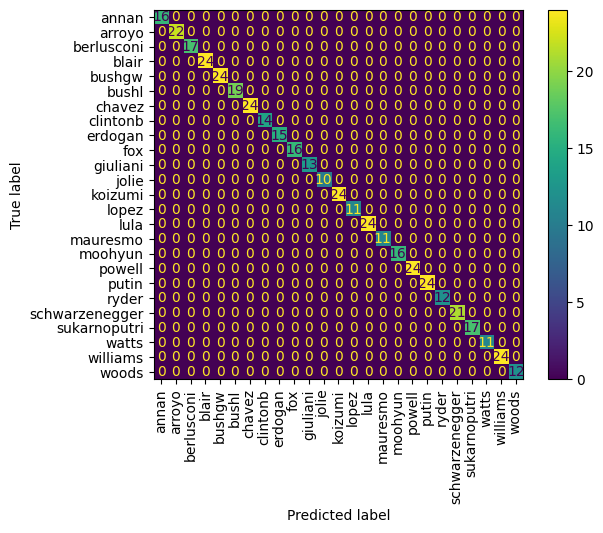

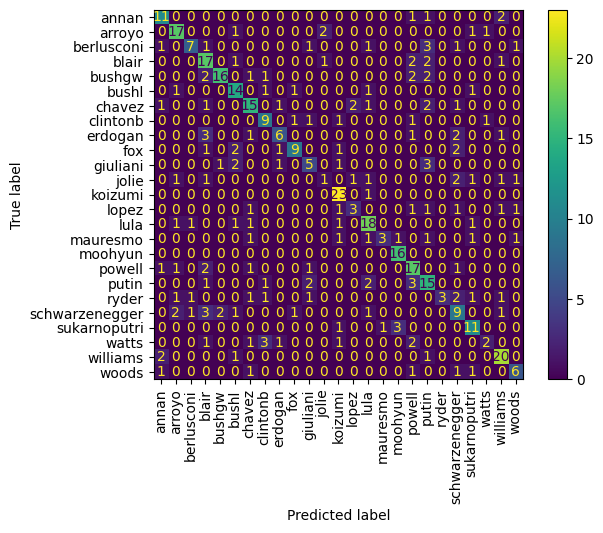

In [30]:
train_predictions = get_labels(model, x_train)
test_predictions = get_labels(model, x_test)

print("train error", f"{classification_error(y_train, train_predictions):.4f}")
print("test error", f"{classification_error(y_test, test_predictions):.4f}")

display_confusion_matrix(y_train, train_predictions, display_labels=LFWUtils.LABELS)
display_confusion_matrix(y_test, test_predictions, display_labels=LFWUtils.LABELS)

## Spatial Information

Our fully-connected layers do ok for this dataset, but they are not very efficient.

There are $2$ main problems with using this approach to extract information about images:

### Every pixel is connected to every other pixel

Consider the first layer after the input layer: every neuron gets information about every pixel. This means that the content at the top-left corner of our image is connected to the content at the bottom-right corner, which is inefficient. We probably don't need our network to consider the entire content of the image at once in order to make decisions. It jumbles the pixel order and just makes the process harder. We might be better off telling our network to consider groups of neighboring pixels, since it's most likely for visual features to come from pixels that are near each other. In other words, we want to extract and preserve some kind of relative _Locality_ from our pixels.

### Not all Arnolds are the same

Let's say our network learned how to classify an Arnold Schwarzenegger that's closer to the left side of the image. If it wants to detect Arnolds on the right side of the image, or towards the top, it has to learn how to activate neurons that are associated with those sections of the image. This is also inefficient because it has to relearn to detect the same thing again, just because it's somewhere else in the image.

Again, what we would like to do is group neighboring pixels, and have the groups go through similar neurons, so that any kind of learning can be applied independent of where shapes are located in the image. The technical name for this property is _Translation Invariance_.

## Convolutions

We could try to come up with our own architecture and write some code for a neural network that doesn't fully connect our pixels, but rather considers neighboring regions of our image in groups of neurons.

But, luckily, some maths combined with intuition from old-school systems and feature engineering can help us here.

There's a type of mathematical operation called a convolution that combines $2$ arbitrary functions into a new function that basically has information about all the possible combinations of inputs for the $2$ original functions.

<!-- The math looks like this for the $1D$ continuous case:<br> -->
<!-- $\displaystyle (f * g)(\tau) = \int_{-\infty}^{\infty}{f(\tau)\ g(1 - \tau)\ d\tau}$ -->

The math looks like this for the $1D$ case:<br>
$\displaystyle (f * g)[n] = \sum_{k=-K}^{K}{f[k]\ \ g[n - k]}$


<br>And the $2D$ case:<br>
$\displaystyle (f * g)[n_x, n_y] = \sum_{k_x=-K}^{K}{\sum_{k_y=-K}^{K}{f[k_x, k_y]\ \ g[n_x - k_x, n_y - k_y]}}$

For the practical, intuitive, definition of this operation when dealing with images, $f[\ ]$ is an image tensor and $g[\ ]$ can be different, but specific, combinations of numbers organized into $2D$ matrices called kernels.

When we _convolve_ the image with the kernel, we calculate every possible overlap of our kernel with the image and, depending on the numbers we choose for the kernel, can extract different types of features from our pixels.

<!-- <img src="./imgs/kernel_slide.jpg" height="256px"/> -->
<img src="https://i.postimg.cc/wMzHtFnJ/kernel-slide.jpg" height="256px"/>

[SOME ANIMATIONS](https://hannibunny.github.io/mlbook/neuralnetworks/convolutionDemos.html)


Classic image processing kernels for sharpening an image and extracting edges:

<!-- <img src="./imgs/image_kernels.jpg" height="300px"/> -->
<img src="https://i.postimg.cc/fTKWdnzb/image-kernels.jpg" height="300px"/>

The nice thing about these kernels is that they operate on neighboring pixels by default, so they already take into account the _locality_ of the features they're trying to detect.

We can now set up a neural network that is a collection of $2D$ image kernels, and let our training algorithm learn parameters for these kernels based on the training data. We don't have to specify that we want an edge-detection kernel, or a curved-shape kernel, or a horizontal blur kernel... the network will learn the kernels that it needs.

And, since the same kernel slides over an entire image during convolution, once the network learns to extract lines on the left side of the image, it also knows how to extract lines on the right side of the image, or on top, or anywhere else. The parameters to the kernel are the same, they just get applied to different neighborhoods of pixels.

If we combine our bank of kernels with another operation to reduce the size of our image as it moves through the network, we can create a type of dynamic filtering that detects whether certain features are present on our image.

<!-- <img src="./imgs/cnn_layers.jpg" height="320px"/> -->
<img src="https://i.postimg.cc/rpdq7DSd/cnn-layers.jpg" height="320px"/>

Then, after we have reduced our feature maps to a small-enough shape we ca use fully-connected layers to finalize our classification.

<!-- <img src="./imgs/cnn_fc.jpg" height="320px"/> -->
<img src="https://i.postimg.cc/XYYjcHqk/cnn-fc.jpg" height="320px"/>

### New Network, New Shape

Right now our input samples are lists of pixels, organized in a `tensor` of shape $(1, 22100)$. In order to use the convolution layers we actually need the images in a $2D$ tensor of shape $(170, 130)$.

CNNs are even more particular about channels: we not only have to be explicit about the number of channels on our images, but this info also has to be in the first dimension of our image tensors.

So, instead of working with the original image shape where each pixel keeps the values for its channels together, like:<br>
$H \times W \times C$ (`height` by `width` by `channel`)

we now have to use a `tensor` made up of single-channel images: all the RED values, then all the GREEN values, then all the BLUE values... so a $3D$ `tensor` of shape: $C \times H \times W$. For our `LFW` images this is $(1, 170, 130)$.

The [`permute()`](https://pytorch.org/docs/stable/generated/torch.permute.html) or [`movedim()`](https://pytorch.org/docs/stable/generated/torch.movedim.html#torch.movedim) functions can be used to reorganize the order of a `tensor`'s dimensions.

In the end, our dataset should be in a `tensor` of shape:<br>
$N \times C \times H \times W$ (`samples`, `channels`, `height`, `width`).

In [31]:
train, test = LFWUtils.train_test_split(0.5)

We're working with grayscale images in this exercise, but the code below should also work for `RGB` images.

In [32]:
iw,ih = LFWUtils.IMAGE_SIZE
n_channels = len(train["pixels"][0][0]) if type(train["pixels"][0][0]) == list else 1
n_samples = len(train["pixels"])

x_train = Tensor(train["pixels"]).reshape(n_samples, LFWUtils.IMAGE_HEIGHT, LFWUtils.IMAGE_WIDTH, n_channels).permute(0,3,1,2)
x_test = Tensor(test["pixels"]).reshape(-1, LFWUtils.IMAGE_HEIGHT, LFWUtils.IMAGE_WIDTH, n_channels).movedim(-1, 1)

y_train = Tensor(train["labels"]).long()
y_test = Tensor(test["labels"]).long()

print("Dataset Samples")
print("\tTrain:", len(x_train))
print("\tTest:", len(x_test))

print("\nDataset Shape:")
print(f"\tTrain:", list(x_train.shape))
print(f"\tTtest:", list(x_test.shape))

print("\nSample Shape:")
print(f"\tTrain:", list(x_train[0].shape))
print(f"\tTest:", list(x_test[0].shape))

Dataset Samples
	Train: 445
	Test: 438

Dataset Shape:
	Train: [445, 1, 170, 130]
	Ttest: [438, 1, 170, 130]

Sample Shape:
	Train: [1, 170, 130]
	Test: [1, 170, 130]


### Check Image

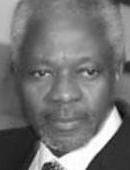

In [33]:
idx = 0
img_t = x_train[idx].permute(1,2,0).reshape(-1, x_train.shape[1])
display(make_image(img_t, width=x_train.shape[3]))

### Define CNN Model

This is how we define a convolution layer:

`nn.Conv2d(Cin, Cout, kernel_size)`

Where `Cin` is the number of input channels, `Cout` is output channels, and `kernel_size` the width of our kernel.

We should still normalize the computations by batch, but this time using the $2D$ version of `BatchNorm()`, and after activation we perform the `MaxPool` operation, which takes the largest value in a $2 \times 2$ region of our activations and condenses them into denser representation of features.

In [34]:
linear_length = 70848

model = nn.Sequential(
  nn.Conv2d(1, 32, 7),
  nn.BatchNorm2d(32),
  nn.ReLU(),
  nn.MaxPool2d(3),

  # More Convs ?

  nn.Flatten(),

  nn.Dropout(0.35),
  nn.Linear(linear_length, len(LFWUtils.LABELS)),
)

learning_rate = 1e-3
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

out = model(x_train)

print("Input shape:", x_train.shape)
print("Output shape:", out.shape)
print("Parameters:", get_num_params(model))

Input shape: torch.Size([445, 1, 170, 130])
Output shape: torch.Size([445, 25])
Parameters: 1772889


In [35]:
for e in range(32):
  optim.zero_grad()
  labels_pred = model(x_train)
  loss = loss_fn(labels_pred, y_train)
  loss.backward()
  optim.step()

  if e % 4 == 3:
    train_predictions = get_labels(model, x_train)
    test_predictions = get_labels(model, x_test)
    train_error = classification_error(y_train, train_predictions)
    test_error = classification_error(y_test, test_predictions)
    print(f"Epoch: {e} loss: {loss.item():.4f}, train error: {train_error:.4f}, test error: {test_error:.4f}")

Epoch: 3 loss: 2.4463, train error: 0.9281, test error: 0.9338
Epoch: 7 loss: 4.5832, train error: 0.3461, test error: 0.6416
Epoch: 11 loss: 1.9402, train error: 0.2472, test error: 0.5845
Epoch: 15 loss: 1.2389, train error: 0.1326, test error: 0.5708
Epoch: 19 loss: 0.6253, train error: 0.0427, test error: 0.4521
Epoch: 23 loss: 0.2452, train error: 0.0180, test error: 0.4292
Epoch: 27 loss: 0.1176, train error: 0.0090, test error: 0.4041
Epoch: 31 loss: 0.0558, train error: 0.0045, test error: 0.3881
